**Projet personnel de reconnaissance d'émotions sur des visages**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import glob
import os
import pickle
import random
from PIL import Image

from skimage.transform import resize

import datasets
from datasets import load_dataset

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator

from keras import Model
from keras import regularizers
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import (Input, Dense, Flatten, Reshape, Rescaling, Convolution2D, MaxPooling2D,
Dropout, RandomFlip, RandomCrop, Concatenate, AveragePooling2D, BatchNormalization, Activation,
Add, Convolution2DTranspose, Convolution1DTranspose, Resizing, RandomRotation)
from keras.optimizers import Adam, RMSprop, Adamax, SGD
from keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, CategoricalCrossentropy
from keras.applications.resnet import ResNet50, preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA #non-supervisé, garde max variance
from sklearn.model_selection import train_test_split


**Définition des chemins pour les fichiers et des 7 émotions**

In [2]:
data_dir_train = "./archive/train/"
data_dir_test = "./archive/test/"
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

**Exploration des données et EDA**

In [81]:
nbr_emotion_train = {}
nbr_emotion_train_perc = {}
for emotion in emotions:
    nbr_emotion_train[emotion] = len(os.listdir(f"{data_dir_train}{emotion}"))
    nbr_emotion_train_perc[emotion] = len(os.listdir(f"{data_dir_train}{emotion}"))/28709
    nbr_emotion_test = {}
nbr_emotion_test_perc = {}
for emotion in emotions:
    nbr_emotion_test[emotion] = len(os.listdir(f"{data_dir_test}{emotion}"))
    nbr_emotion_test_perc[emotion] = len(os.listdir(f"{data_dir_test}{emotion}"))/7178
display(nbr_emotion_train, nbr_emotion_test)

{'angry': 3995,
 'disgust': 436,
 'fear': 4097,
 'happy': 7215,
 'neutral': 4965,
 'sad': 4830,
 'surprise': 3171}

{'angry': 958,
 'disgust': 111,
 'fear': 1024,
 'happy': 1774,
 'neutral': 1233,
 'sad': 1247,
 'surprise': 831}

{'angry': 958,
 'disgust': 111,
 'fear': 1024,
 'happy': 1774,
 'neutral': 1233,
 'sad': 1247,
 'surprise': 831}

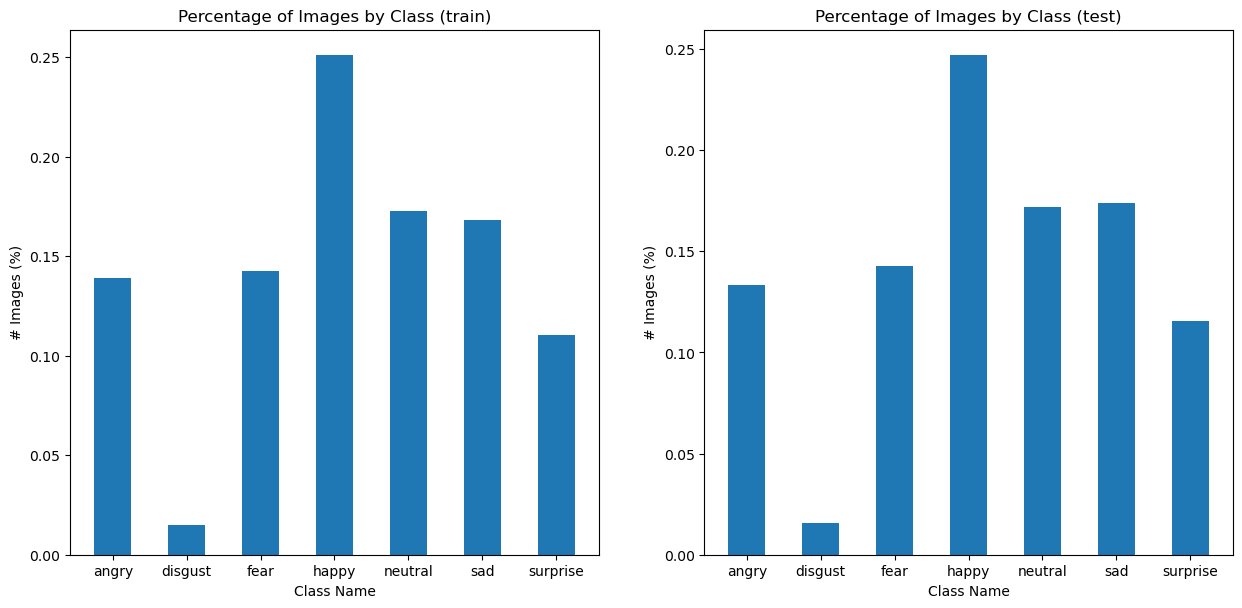

In [78]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.bar(nbr_emotion_train_perc.keys(), nbr_emotion_train_perc.values(), width = .5);plt.title("Percentage of Images by Class (train)");plt.xlabel('Class Name');plt.ylabel('# Images (%)')
plt.subplot(222)
plt.bar(nbr_emotion_test_perc.keys(), nbr_emotion_test_perc.values(), width = .5);plt.title("Percentage of Images by Class (test)");plt.xlabel('Class Name');plt.ylabel('# Images (%)')
plt.show()

**Exemple de boucle d'itération à tavers les différents dossiers**

In [6]:
for emotion in emotions:
    # Set image path
    file_path_type = [f"{data_dir_train}{emotion}/*.jpg"]
    display(file_path_type)

['./archive/train/angry/*.jpg']

['./archive/train/disgust/*.jpg']

['./archive/train/fear/*.jpg']

['./archive/train/happy/*.jpg']

['./archive/train/neutral/*.jpg']

['./archive/train/sad/*.jpg']

['./archive/train/surprise/*.jpg']

**Création dataframe global train et test**

In [7]:
# data_train = []

# for i in glob.glob(f"{data_dir_train}**/*.jpg", recursive=True):
#     data_unflatten = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
#     data_flatten = data_unflatten.flatten()
#     data_train.append(data_flatten)
# df_train=pd.DataFrame(data_train)

# data_test = []

# for i in glob.glob(f"{data_dir_test}**/*.jpg", recursive=True):
#     data_unflatten = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
#     data_flatten = data_unflatten.flatten()
#     data_test.append(data_flatten)
# df_tot_test=pd.DataFrame(data_test)

**Sauvegarde et chargement du dataframe global  train et test**

In [8]:
# df_tot_train = df_train.copy()
# df_tot_train.to_csv("C:/Users/admindc/Documents/Projet_final/df_tot_train.csv", compression="zip")
# df_tot_test = df_tot_test.copy()
# df_tot_test.to_csv("C:/Users/admindc/Documents/Projet_final/df_tot_test.csv", compression="zip")

In [9]:
df_tot_train_load = pd.read_csv("C:/Users/admindc/Documents/Projet_final/df_tot_train.csv",compression="zip")
df_tot_train = df_tot_train_load.drop(['Unnamed: 0'], axis=1)
df_tot_test_load = pd.read_csv("C:/Users/admindc/Documents/Projet_final/df_tot_test.csv",compression="zip")
df_tot_test = df_tot_test_load.drop(['Unnamed: 0'], axis=1)

In [23]:
df_tot_train

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,50,32,15,11,12,10,10,8,15,10,...,160,157,156,152,148,151,141,143,136,83
1,29,24,29,11,15,22,26,11,7,17,...,60,109,165,148,75,49,33,15,24,24
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,155,138,98,112,94,97,111,107,101,84,...,102,97,95,92,94,101,108,111,112,109
4,211,215,220,221,219,216,213,210,207,205,...,171,170,168,162,170,169,160,159,156,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28704,27,26,26,26,27,27,28,28,33,34,...,49,49,46,45,43,41,39,37,37,36
28705,7,6,13,39,76,58,29,21,16,20,...,136,153,156,159,231,255,255,255,252,255
28706,124,129,125,123,129,128,127,128,131,70,...,144,197,255,248,251,252,250,250,243,251
28707,242,242,242,216,110,42,20,41,37,14,...,145,190,214,227,146,139,149,170,195,203


**PCA**

In [10]:
pca = PCA().fit(df_tot_train)
X_pca = pca.transform(df_tot_train)

(0.0, 2305.0)

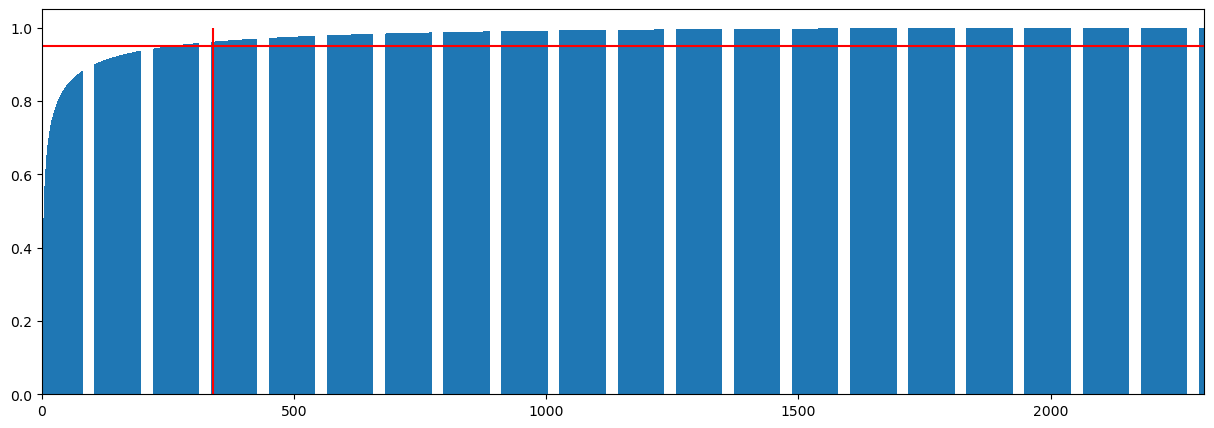

In [11]:
CVar = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(15,5))
plt.bar(np.arange(1, 1+ X_pca.shape[1]),CVar)
plt.hlines(0.95, 0, 1+ X_pca.shape[1], color='red')
plt.vlines(340, 0, 1,color = 'red')
plt.xlim(0,1+ X_pca.shape[1])

In [12]:
pca = PCA(n_components=340).fit(df_tot_train)
components = pca.transform(df_tot_train)
projected = pca.inverse_transform(components)
dataframe_proj = pd.DataFrame(projected)

**Visualisation de la PCA**

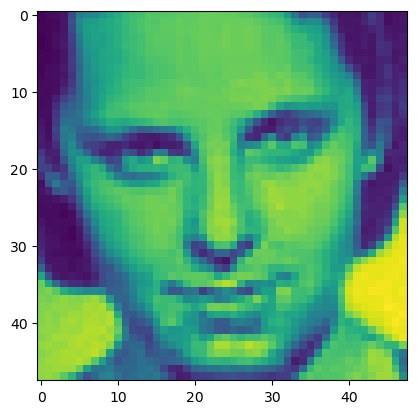

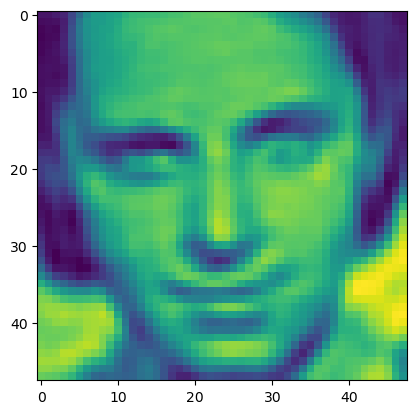

In [13]:
series_obj = df_tot_train.iloc[20000]
series_obj1 = dataframe_proj.iloc[20000]
arr = series_obj.values
arr1 = series_obj1.values
reshaped_arr = arr.reshape((48, 48))
reshaped_arr1 = arr1.reshape((48, 48))
plt.figure()
plt.imshow(reshaped_arr)
plt.figure()
plt.imshow(reshaped_arr1)
plt.show()

**Moyenne et variance globale**

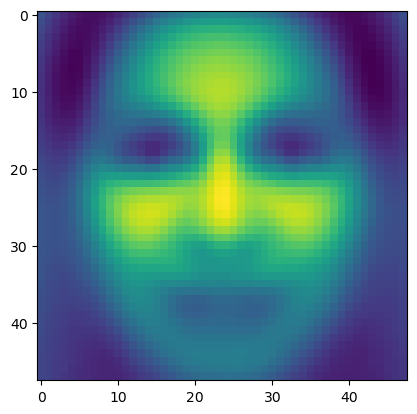

In [14]:
series_obj = pd.Series(df_tot_train.mean())
arr = series_obj.values
reshaped_arr = arr.reshape((48, 48))
plt.imshow(reshaped_arr)
plt.show()

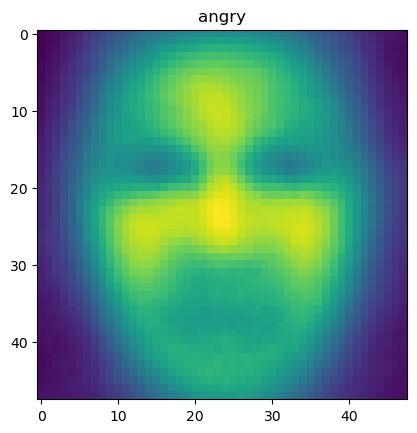

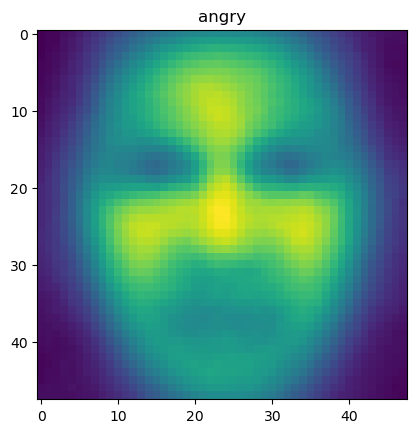

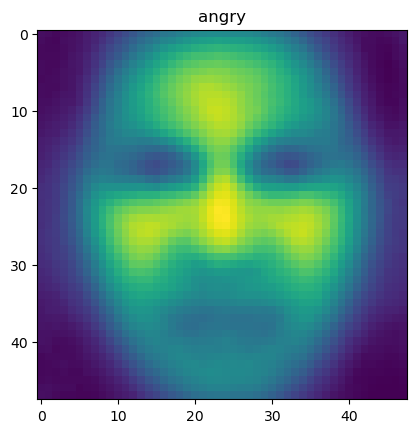

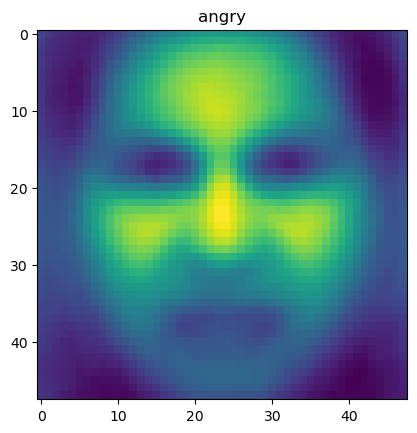

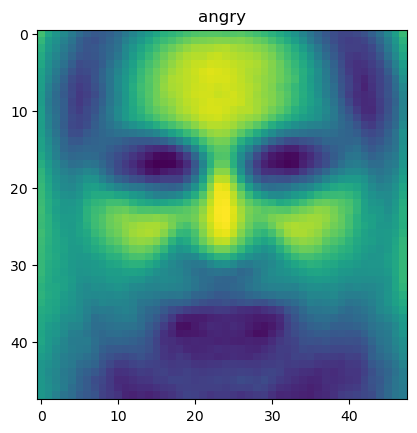

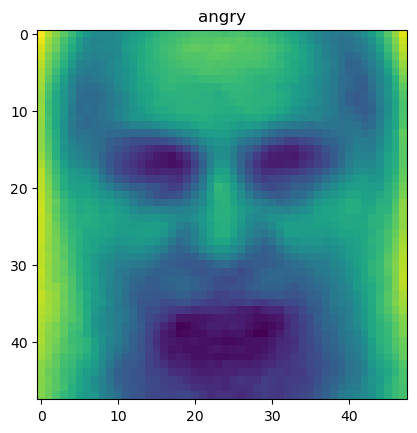

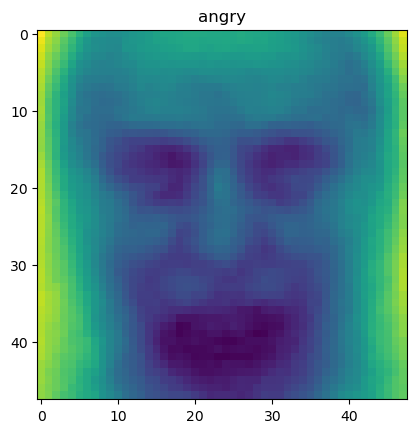

In [67]:
range_j = np.arange(-3 , 4, 1)
for i in emotions [0:1]:
    for j in range_j:
        series_obj = pd.Series(d[f"df_{i}"].mean()+j*d[f"df_{i}"].std())
        arr = series_obj.values
        reshaped_arr = arr.reshape((48, 48))
        plt.figure()
        plt.imshow(reshaped_arr)
        plt.title(i)

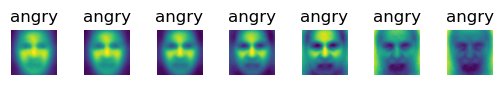

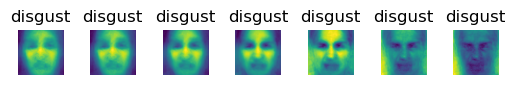

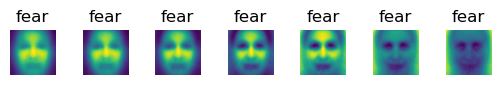

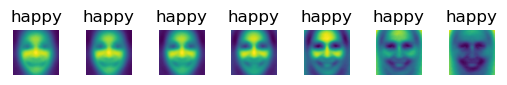

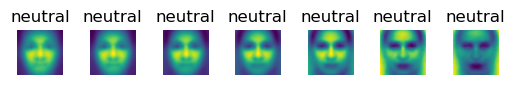

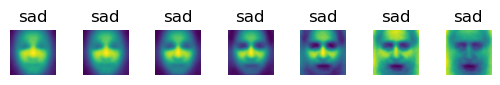

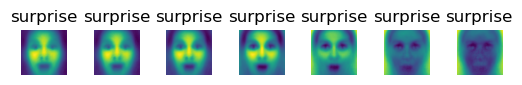

In [65]:
range_j = np.arange(-3 , 4, 1)
k_i = 0
for i in emotions:
    k_i = 0
    k_i += 1
    for j in range_j:
        k = j+3
        series_obj = pd.Series(d[f"df_{i}"].mean()+j*d[f"df_{i}"].std())
        arr = series_obj.values
        reshaped_arr = arr.reshape((48, 48))
        plt.subplot(7,7,k+k_i)
        plt.imshow(reshaped_arr)
        plt.axis('off')           
        plt.title(i)
    plt.show()


# **Méthode de travail par chaque émotions**

**Définir les catégories et afficher une image aléatoire de chacunes**

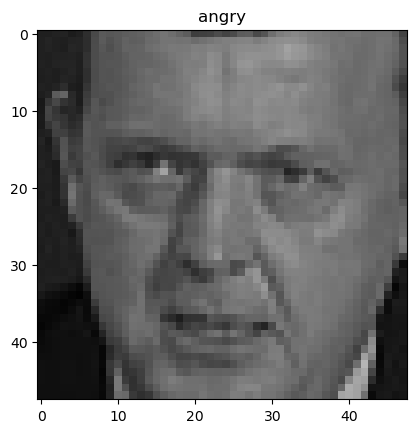

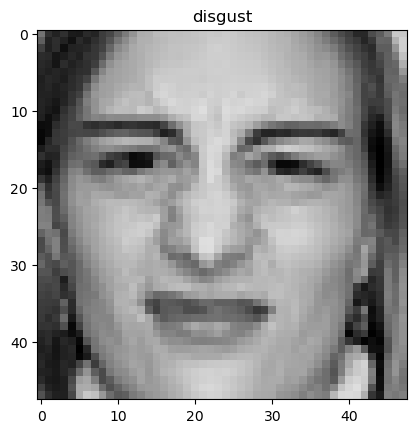

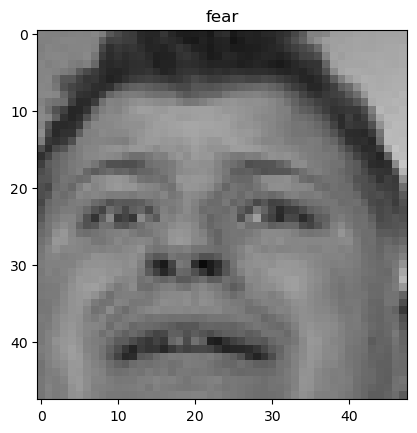

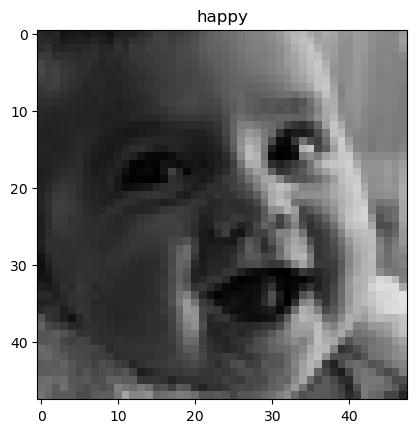

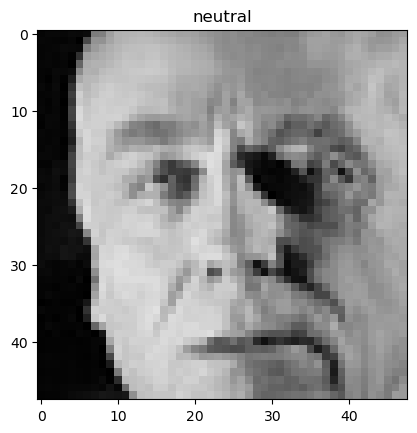

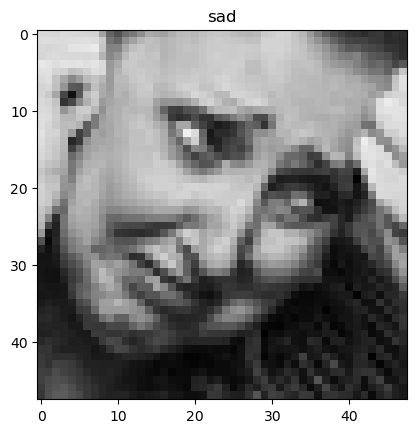

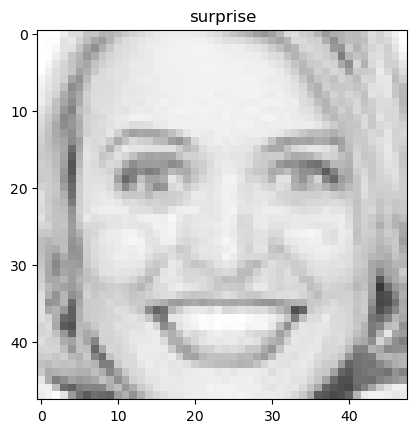

In [16]:
for emotion in emotions:
    # Set image path
    file_path_type = [f"{data_dir_train}{emotion}/*.jpg"] # Exemple : file_path_type = "./archive/train/angry/Training_3908.jpg"
    images = glob.glob(random.choice(file_path_type))
    random_image = random.choice(images)
    
    # Read input image:
    inputImage = cv2.imread(random_image)
    grayscaleImage = inputImage.copy()

    plt.figure()
    plt.title(emotion)
    plt.imshow(grayscaleImage)

**Automatisation de la création d'un dictionnaire de dataframes pour chaque émotions**

In [17]:
# d = {}
# for i in emotions:
#     data = []
#     for j in glob.glob(f"{data_dir_train}{i}/*.jpg", recursive=True):
#         data_unflatten = cv2.imread(j, cv2.IMREAD_GRAYSCALE)
#         data_flatten = data_unflatten.flatten()
#         data.append(data_flatten)
#     d["df_" + i] = pd.DataFrame(data)

**Sauvegarde du dictionnaire de dataframes pour chaque émotions**

In [18]:
# with open('dictionaire_df.pickle', 'wb') as handle:
#     pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

**Chargement du dictionnaire de dataframes pour chaque émotions**

In [19]:
with open('dictionaire_df.pickle', 'rb') as handle:
    d = pickle.load(handle)

**Sauvegarde de chaque dataframe de chaque émotions**

In [20]:
# for i in emotions:
#     d["df_" + i].to_csv(f"C:/Users/admindc/Documents/Projet_final/{'df_' + i}.csv", compression="zip")

**Affichage des photos moyennes de chaque émotions**

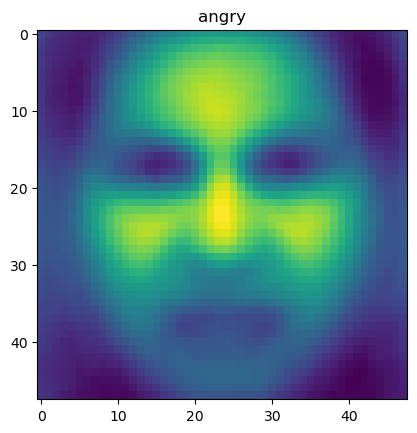

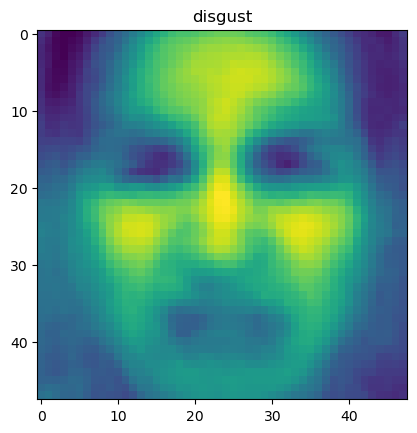

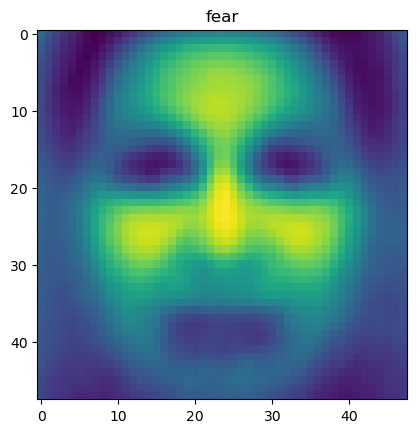

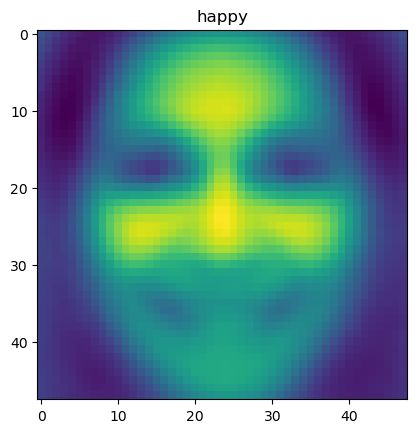

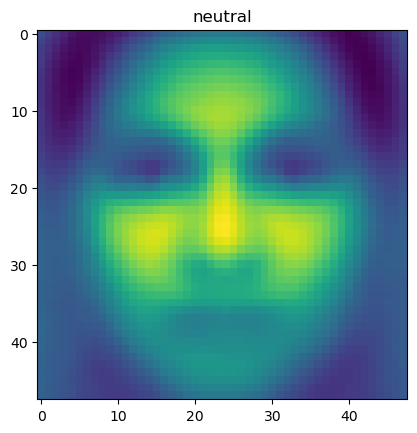

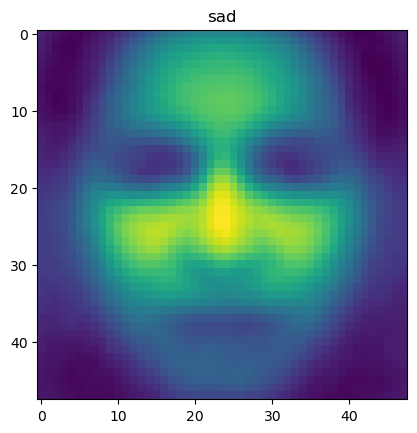

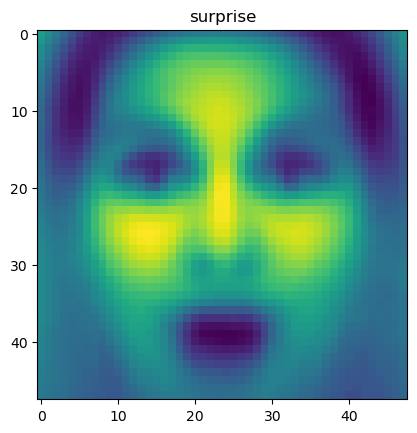

In [21]:
for i in emotions:
    series_obj = pd.Series(d[f"df_{i}"].mean())
    arr = series_obj.values
    reshaped_arr = arr.reshape((48, 48))
    plt.figure()
    plt.imshow(reshaped_arr)
    plt.title(i)

# **Recher d'anomalies parmmis les photos fain d'éliminer de potentiels outliers**

In [82]:
x = 0.001 # valeur abbérante tester 1%
IsFo = IsolationForest(contamination=x, random_state=42)

IsFo.fit(df_tot_train)

c:\Users\admindc\anaconda3\envs\tf_devia\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.001, random_state=42)

In [83]:
In_Out = IsFo.predict(df_tot_train)
In_Out

array([ 1,  1, -1, ...,  1,  1,  1])

In [84]:
Is_Out = (In_Out == -1)
Is_Out.sum()

29

C:\Users\admindc\AppData\Local\Temp\ipykernel_5452\4048691123.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


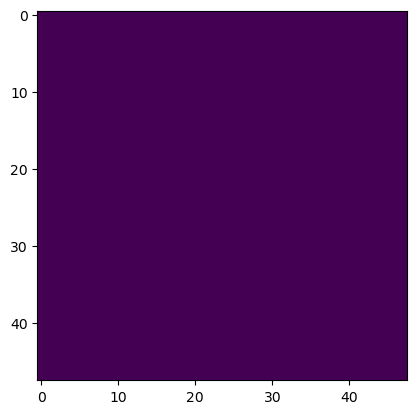

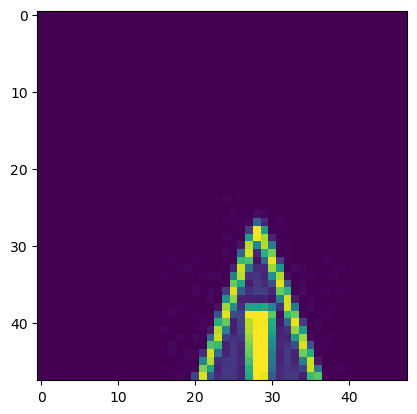

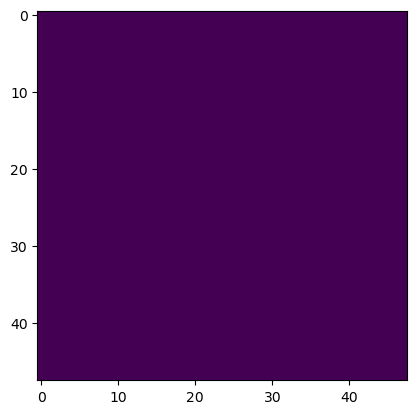

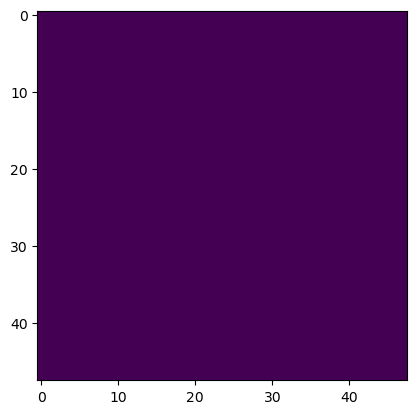

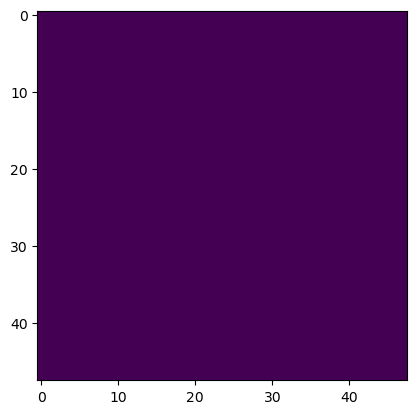

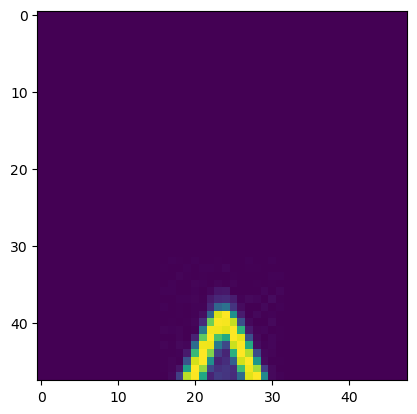

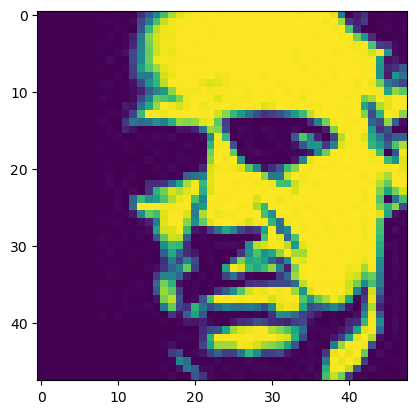

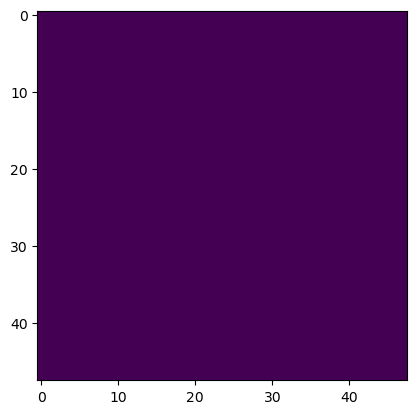

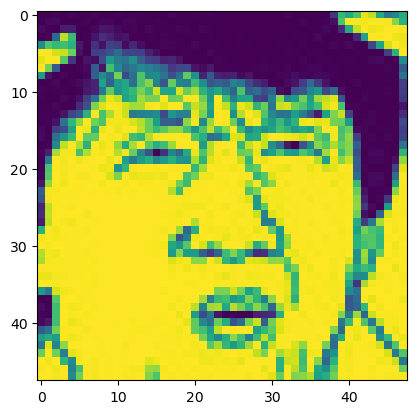

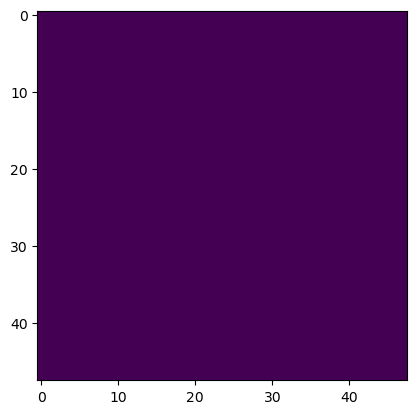

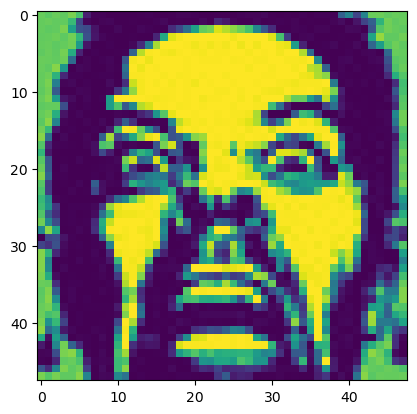

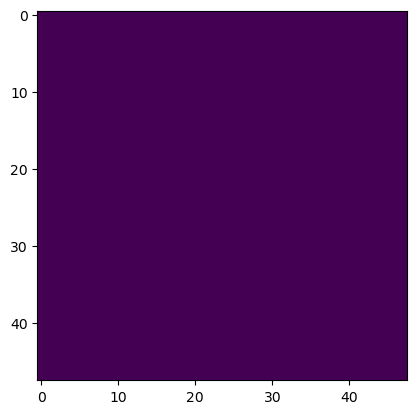

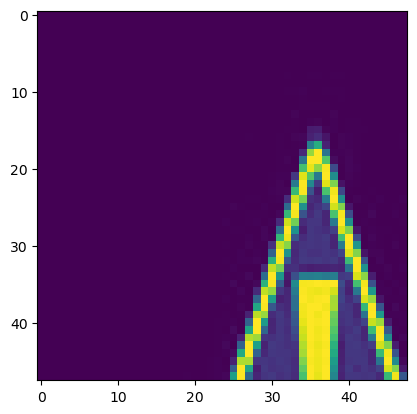

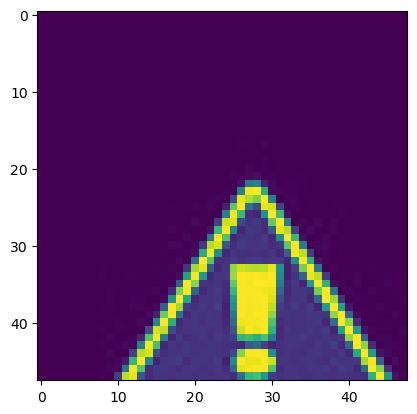

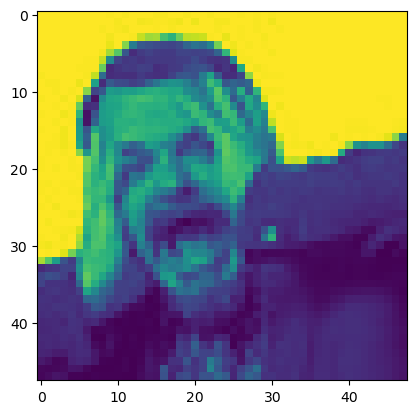

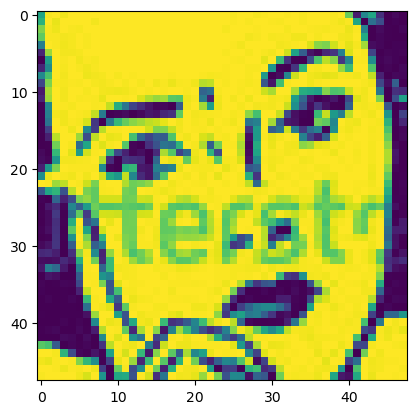

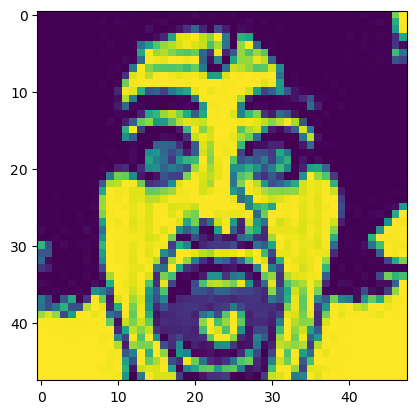

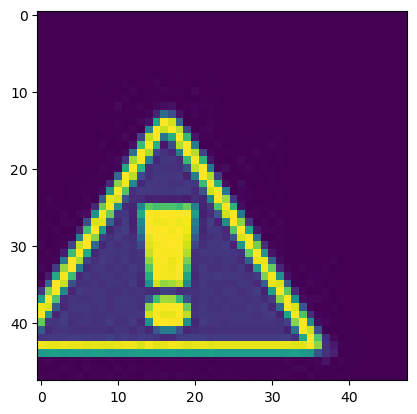

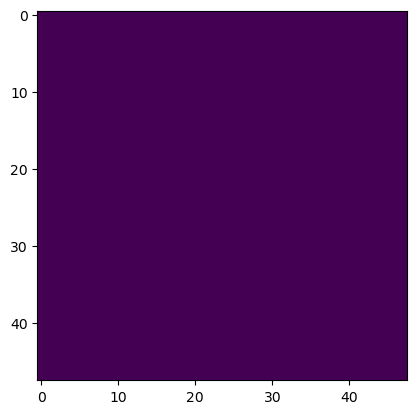

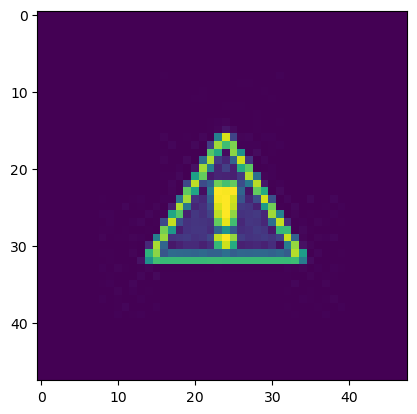

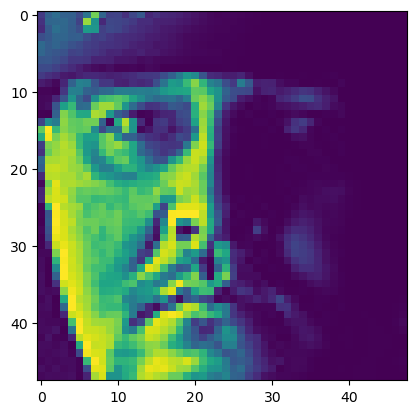

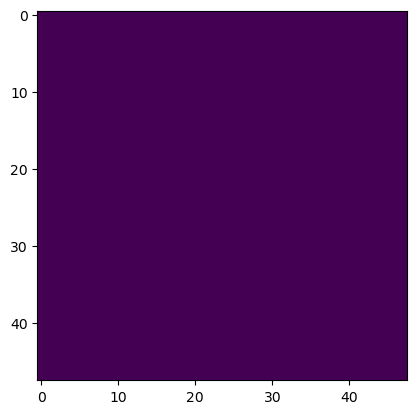

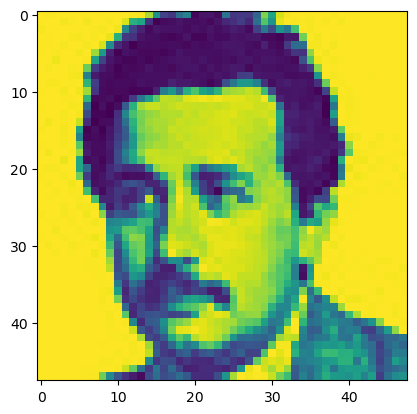

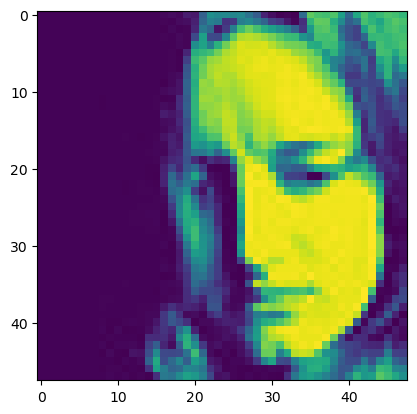

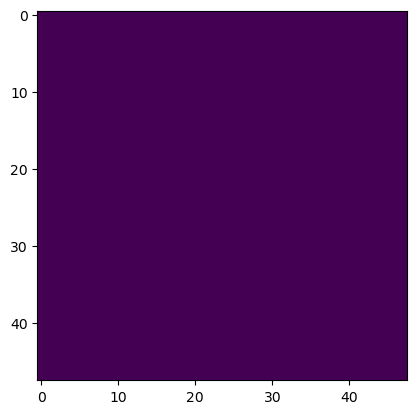

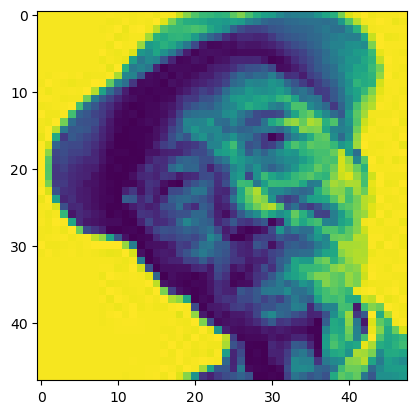

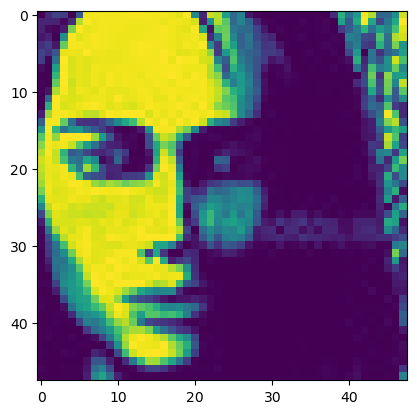

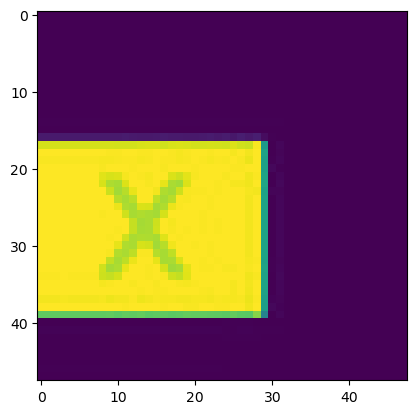

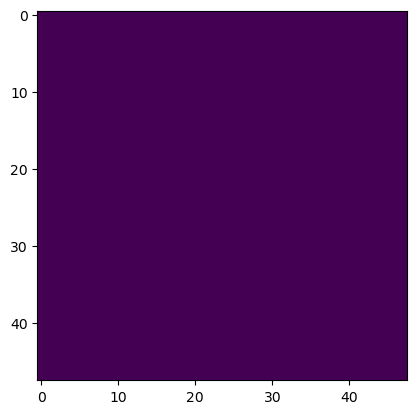

<Figure size 640x480 with 0 Axes>

In [85]:
df_anom = df_tot_train[Is_Out]
for i in range(len(df_anom)):
    series_obj = pd.Series(df_anom.iloc[i])
    arr = series_obj.values
    reshaped_arr = arr.reshape((48, 48))
    plt.imshow(reshaped_arr)
    plt.figure()
